In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
import importlib

In [3]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_370.pth"

In [4]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 48,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }


Using device: cuda
Channels : 24


In [5]:
importlib.reload(score)
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = score.ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = score.VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_3895203/1812132184.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_370.pth, trained until epoch 370


In [6]:
for batch, dic in testloader:
    t = torch.rand(batch.shape[0], dtype=batch.dtype)
    t[0] = 0.8
    t[1] = 0.9
    t[2] = 1
    c = dic["context"]
    c = c.to(device)
    batch = batch.to(device)
    t = t.to(device)
    x_t = vpsde.forward(batch, t , train=False)
    x_0 = vpsde.denoise(x_t,t,c)
    print(vpsde.mu(t[:3]))
    print(vpsde.sigma(t[:3]))
    break

tensor([0.1313, 0.0480, 0.0050], device='cuda:0')
tensor([0.9914, 0.9989, 1.0000], device='cuda:0')


<h1> Display Batch </h1>

torch.Size([48, 24, 64, 64])
T2m  Mean : 9.666783332824707, Var: 1.7260661125183105
U10m  Mean : 6.76222562789917, Var: 2.2560789585113525
T2m  Mean : -2.1431262493133545, Var: 1.2258049249649048
U10m  Mean : 2.820300340652466, Var: 1.0639300346374512
T2m  Mean : 9.697907447814941, Var: 1.033209204673767
U10m  Mean : 5.1306328773498535, Var: 1.3341742753982544
T2m  Mean : 3.7982301712036133, Var: 0.8716974854469299
U10m  Mean : 3.304548501968384, Var: 1.4309782981872559
T2m  Mean : 26.62192726135254, Var: 3.777132511138916
U10m  Mean : 3.0298852920532227, Var: 0.8539000749588013


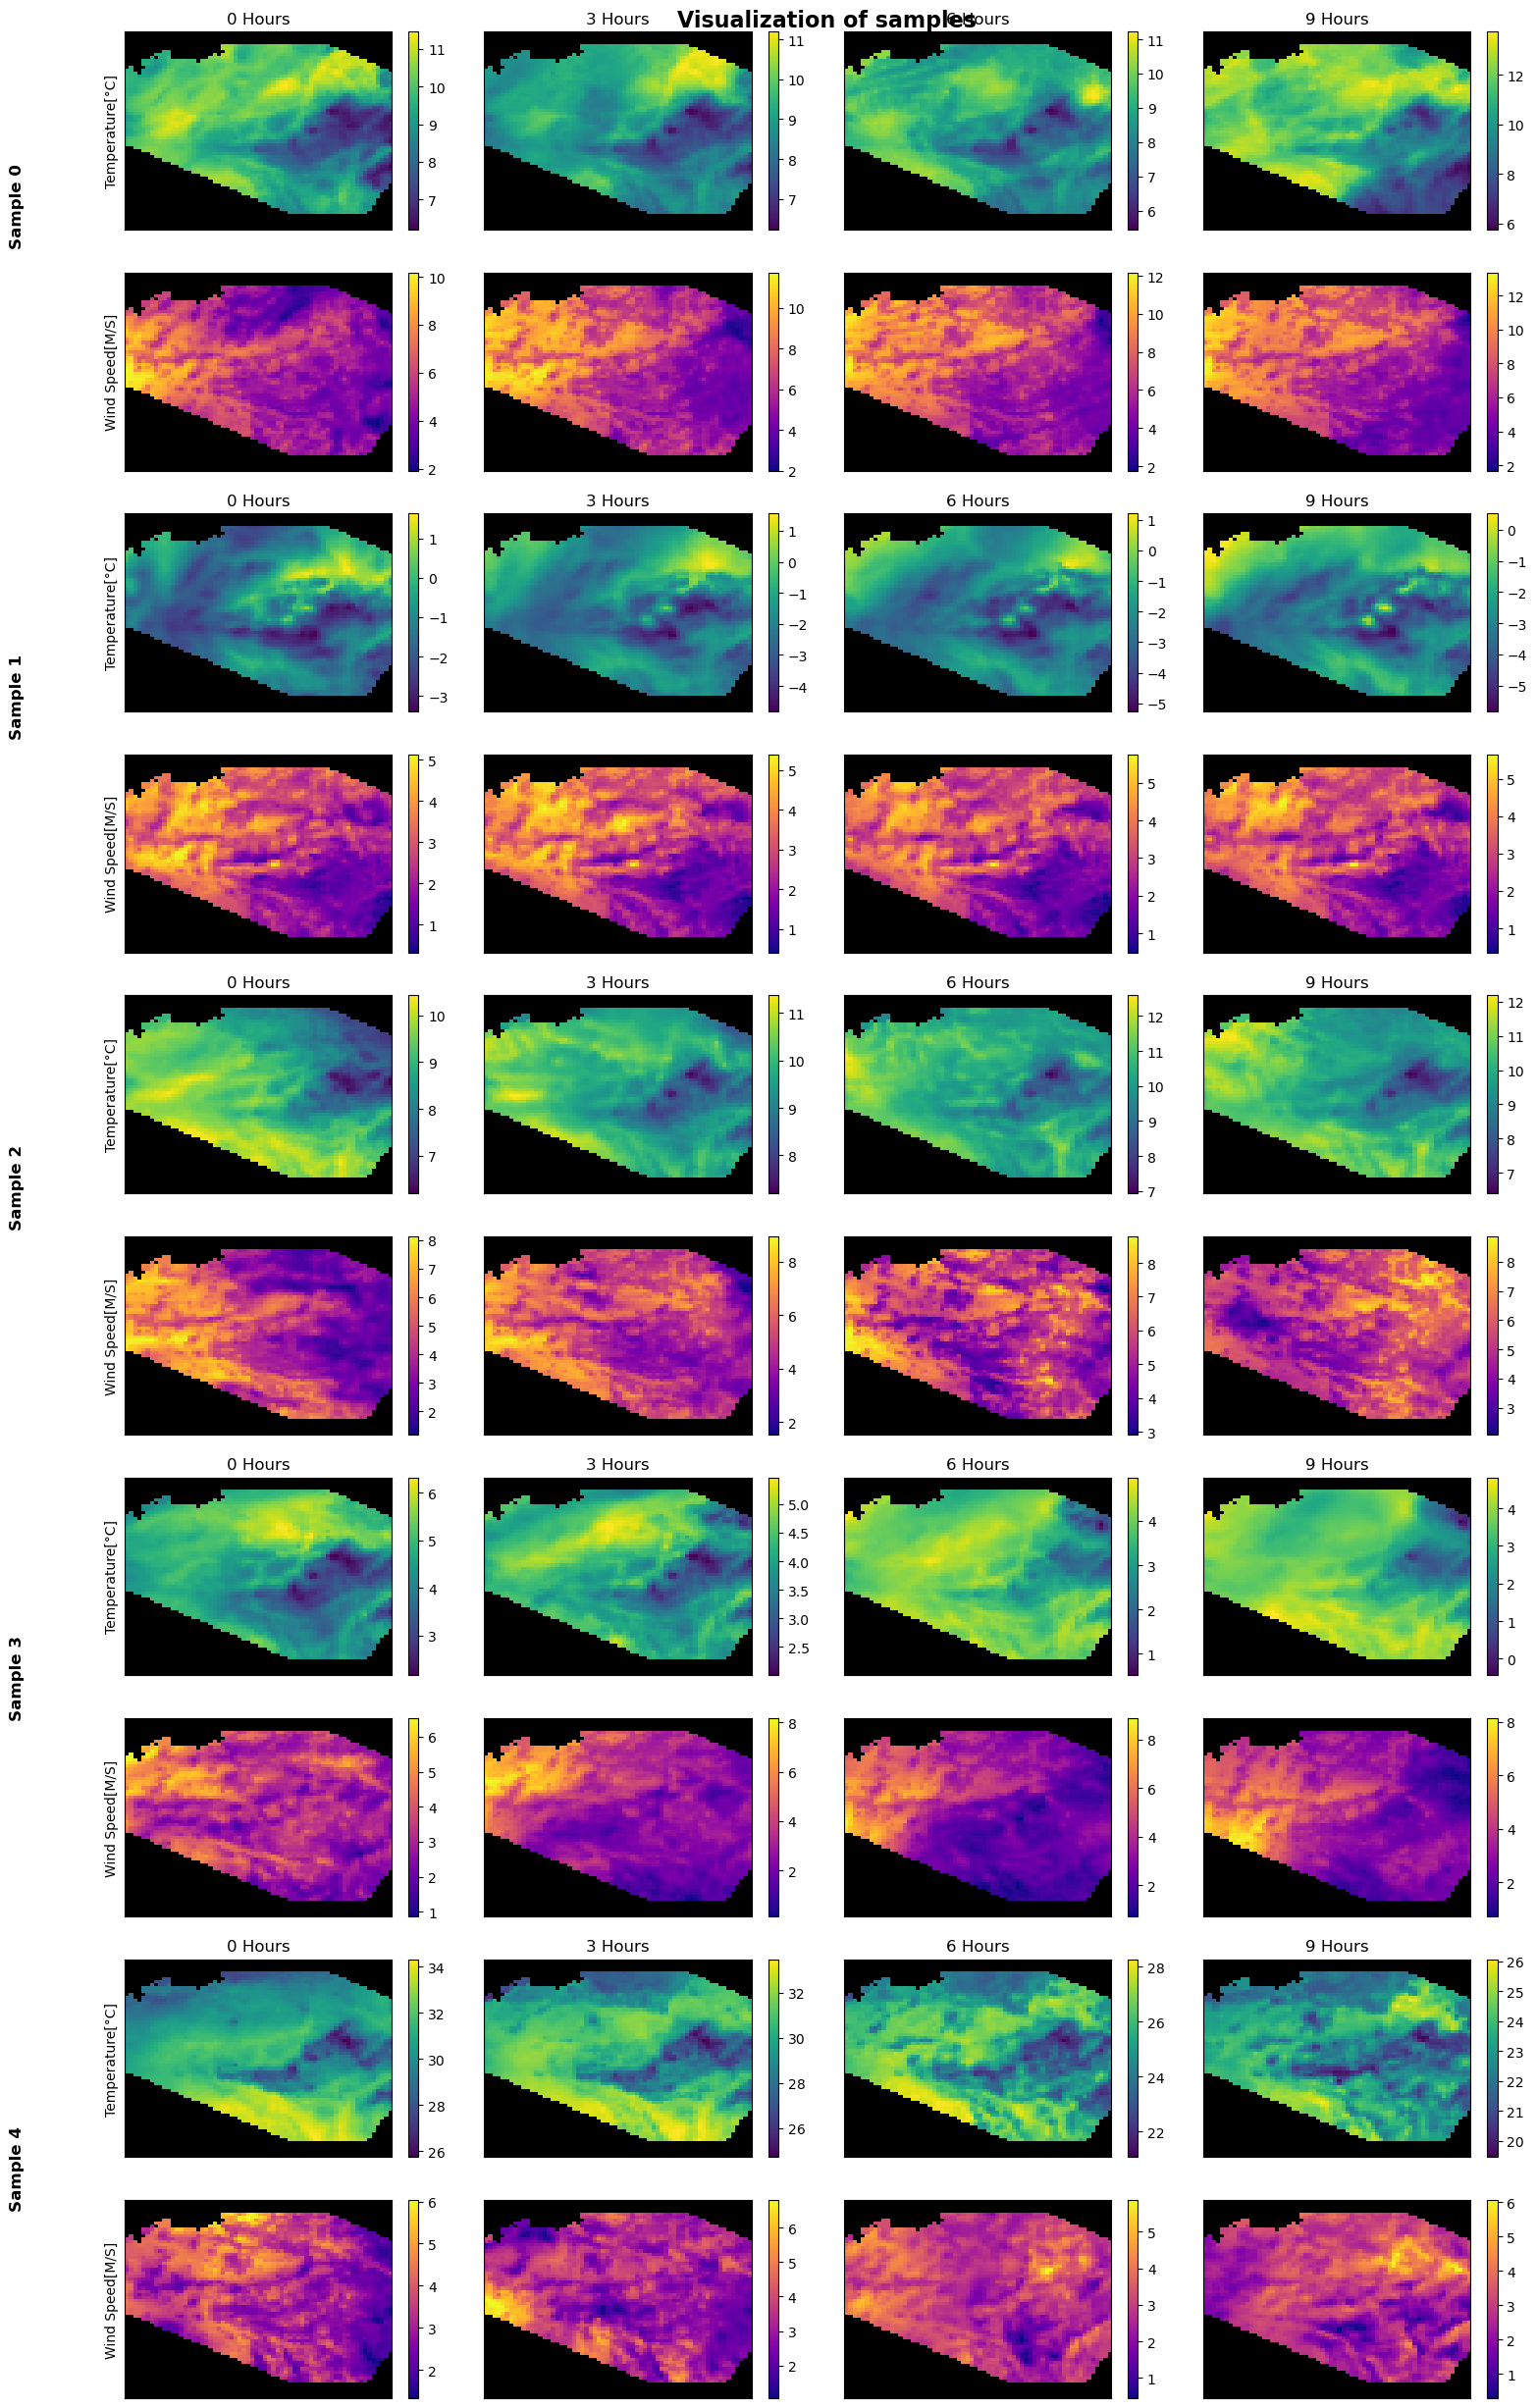

In [7]:
from utils import plot_sample
PATH = Path('.')
path_unnorm = PATH / "data/processed/train.h5"
info = {'var_index': ['T2m', 'U10m'], 'channels': 2, 'window': 12}

batch_cpu = batch.detach().cpu()
fig = plot_sample(batch_cpu, info, mask_cpu, samples=5, step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1> Load and Plot Samples</h1>

In [8]:
# Load Samples
c = c.to(torch.float32).to(device)
c = c.repeat(10,1,1,1)

sample = vpsde.sample(mask,c=c[:100],shape=(100,),steps=2, corrections=0)
#sample = vpsde.ddpm_sample(mask,shape=(8,),c=c[:8],steps=10)

hello


100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.65it/s]


torch.Size([100, 24, 64, 64])
T2m  Mean : 11.199419975280762, Var: 6.676287651062012
U10m  Mean : 4.6259260177612305, Var: 4.719057083129883
T2m  Mean : 13.531638145446777, Var: 7.360316276550293
U10m  Mean : 0.21990813314914703, Var: 3.948479652404785
T2m  Mean : 22.225616455078125, Var: 7.013824939727783
U10m  Mean : 4.380927085876465, Var: 4.504245281219482
T2m  Mean : 9.987787246704102, Var: 8.533618927001953
U10m  Mean : 2.5579795837402344, Var: 4.113137722015381
T2m  Mean : -1.9660465717315674, Var: 6.603165626525879
U10m  Mean : 3.573223114013672, Var: 3.7733750343322754
T2m  Mean : 20.212553024291992, Var: 6.830306529998779
U10m  Mean : 5.2024970054626465, Var: 4.111883163452148
T2m  Mean : 12.296026229858398, Var: 7.131009101867676
U10m  Mean : 4.450595378875732, Var: 4.022576808929443
T2m  Mean : 21.645639419555664, Var: 5.771924018859863
U10m  Mean : 2.3208768367767334, Var: 5.745083808898926


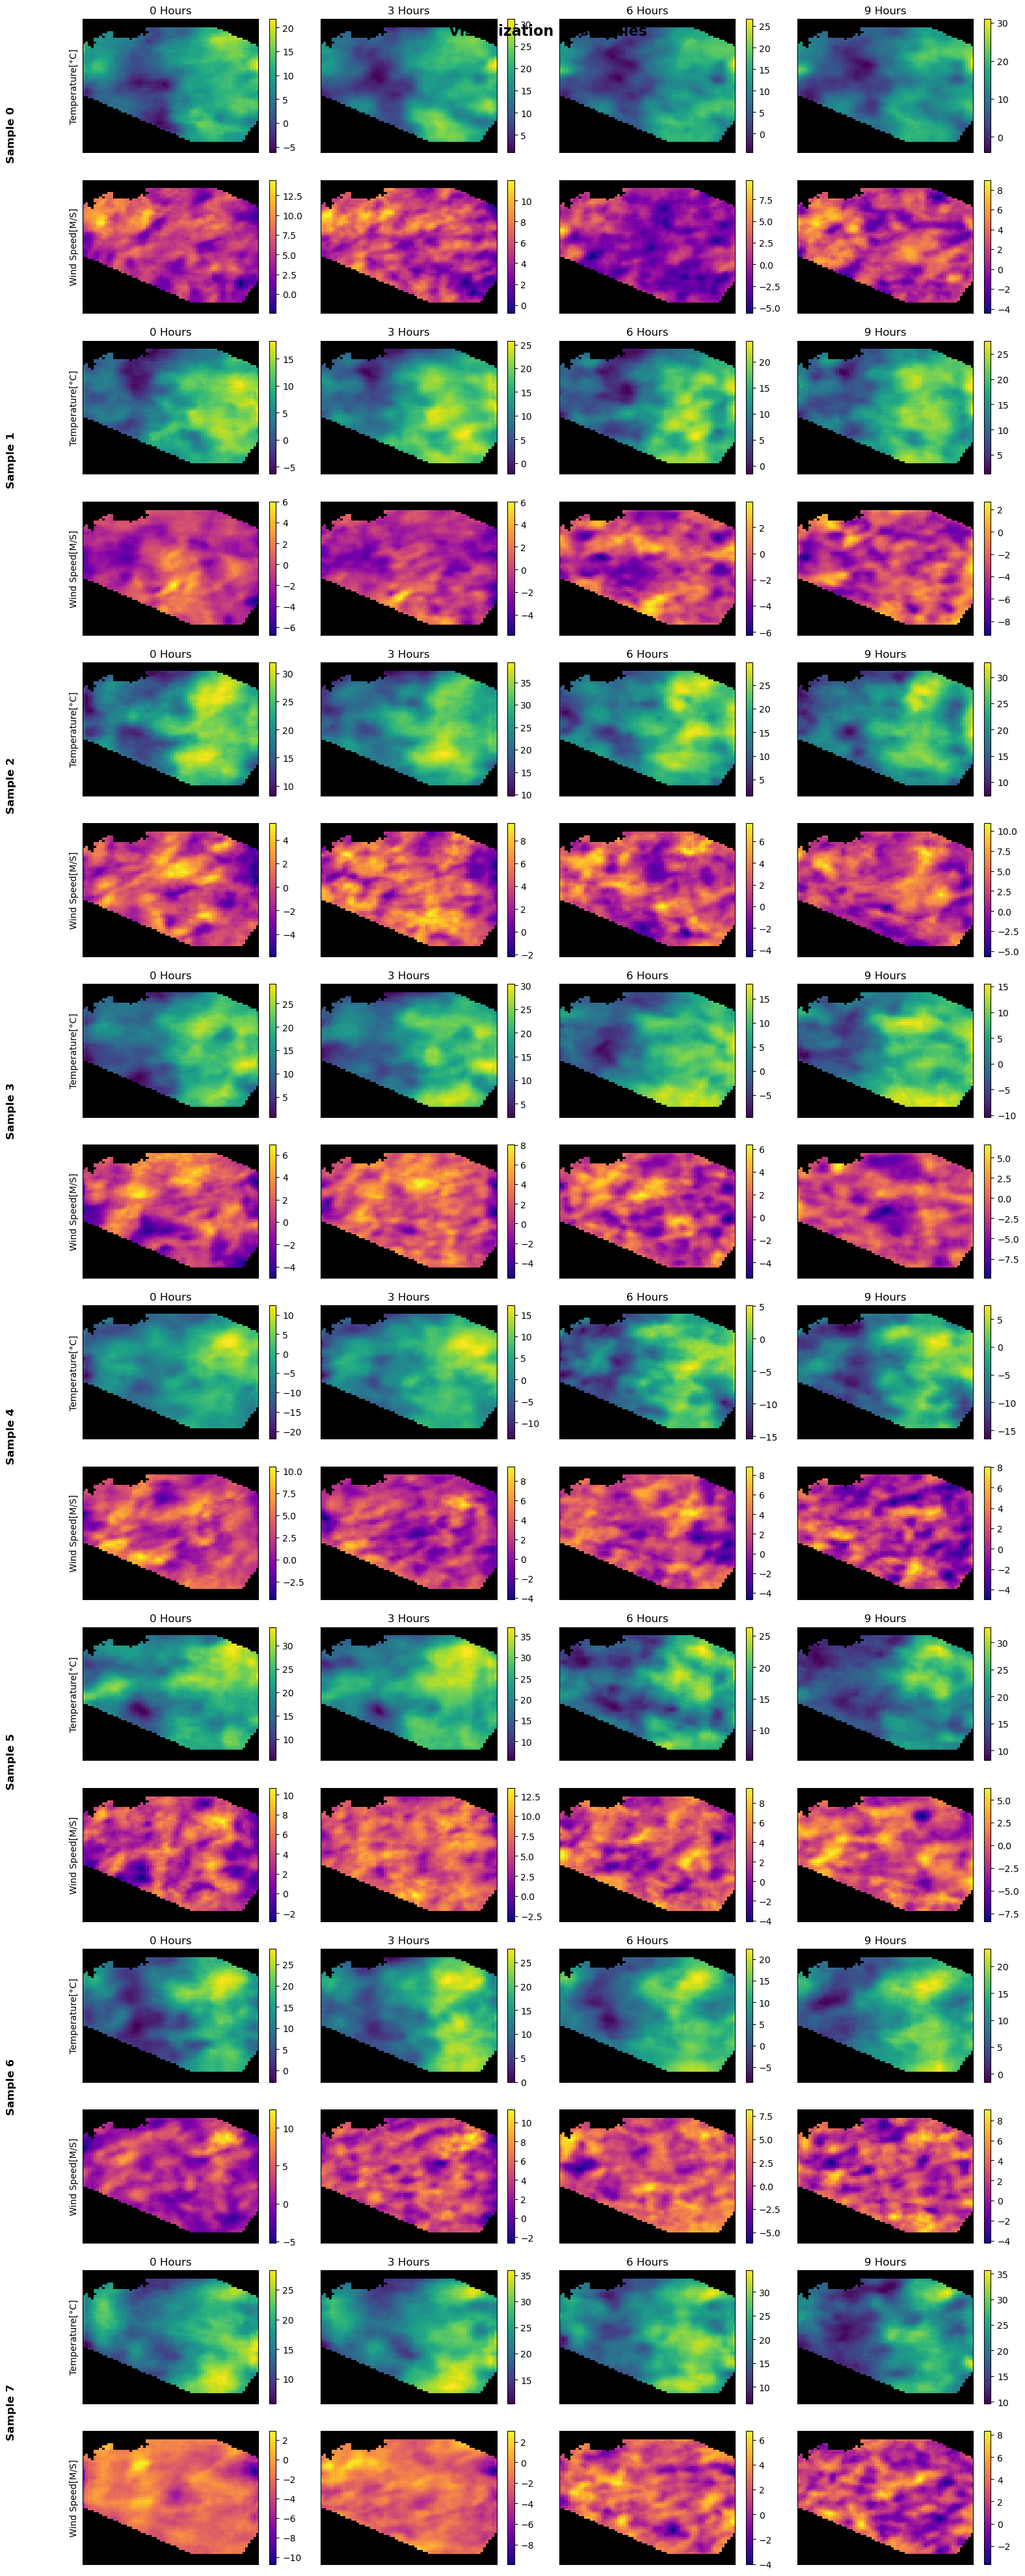

In [9]:
sample_cpu = sample.detach().cpu()
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(sample_cpu,info,mask_cpu,samples=8,step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1>Plot : Batch, Noised Batch and Unnoising of Noised Batch</h1>

torch.Size([144, 24, 64, 64])
T2m  Mean : 12.64405345916748, Var: 1.299829363822937
U10m  Mean : 3.3048784732818604, Var: 1.0086430311203003
T2m  Mean : 10.65589714050293, Var: 7.273653984069824
U10m  Mean : 3.9200503826141357, Var: 2.1111133098602295
T2m  Mean : 12.491242408752441, Var: 1.2290167808532715
U10m  Mean : 3.298924446105957, Var: 0.7148923277854919
T2m  Mean : 8.436080932617188, Var: 1.096491813659668
U10m  Mean : 4.4069600105285645, Var: 1.4603081941604614
T2m  Mean : 10.376242637634277, Var: 7.321969032287598
U10m  Mean : 4.014598846435547, Var: 2.1362600326538086
T2m  Mean : 10.341277122497559, Var: 1.7324141263961792
U10m  Mean : 4.096883773803711, Var: 1.206703543663025
T2m  Mean : 5.0110554695129395, Var: 1.2796790599822998
U10m  Mean : 3.7615773677825928, Var: 1.1854467391967773
T2m  Mean : 10.373820304870605, Var: 7.298419952392578
U10m  Mean : 4.017990589141846, Var: 2.1389641761779785
T2m  Mean : 11.335916519165039, Var: 15.515536308288574
U10m  Mean : 6.08712291

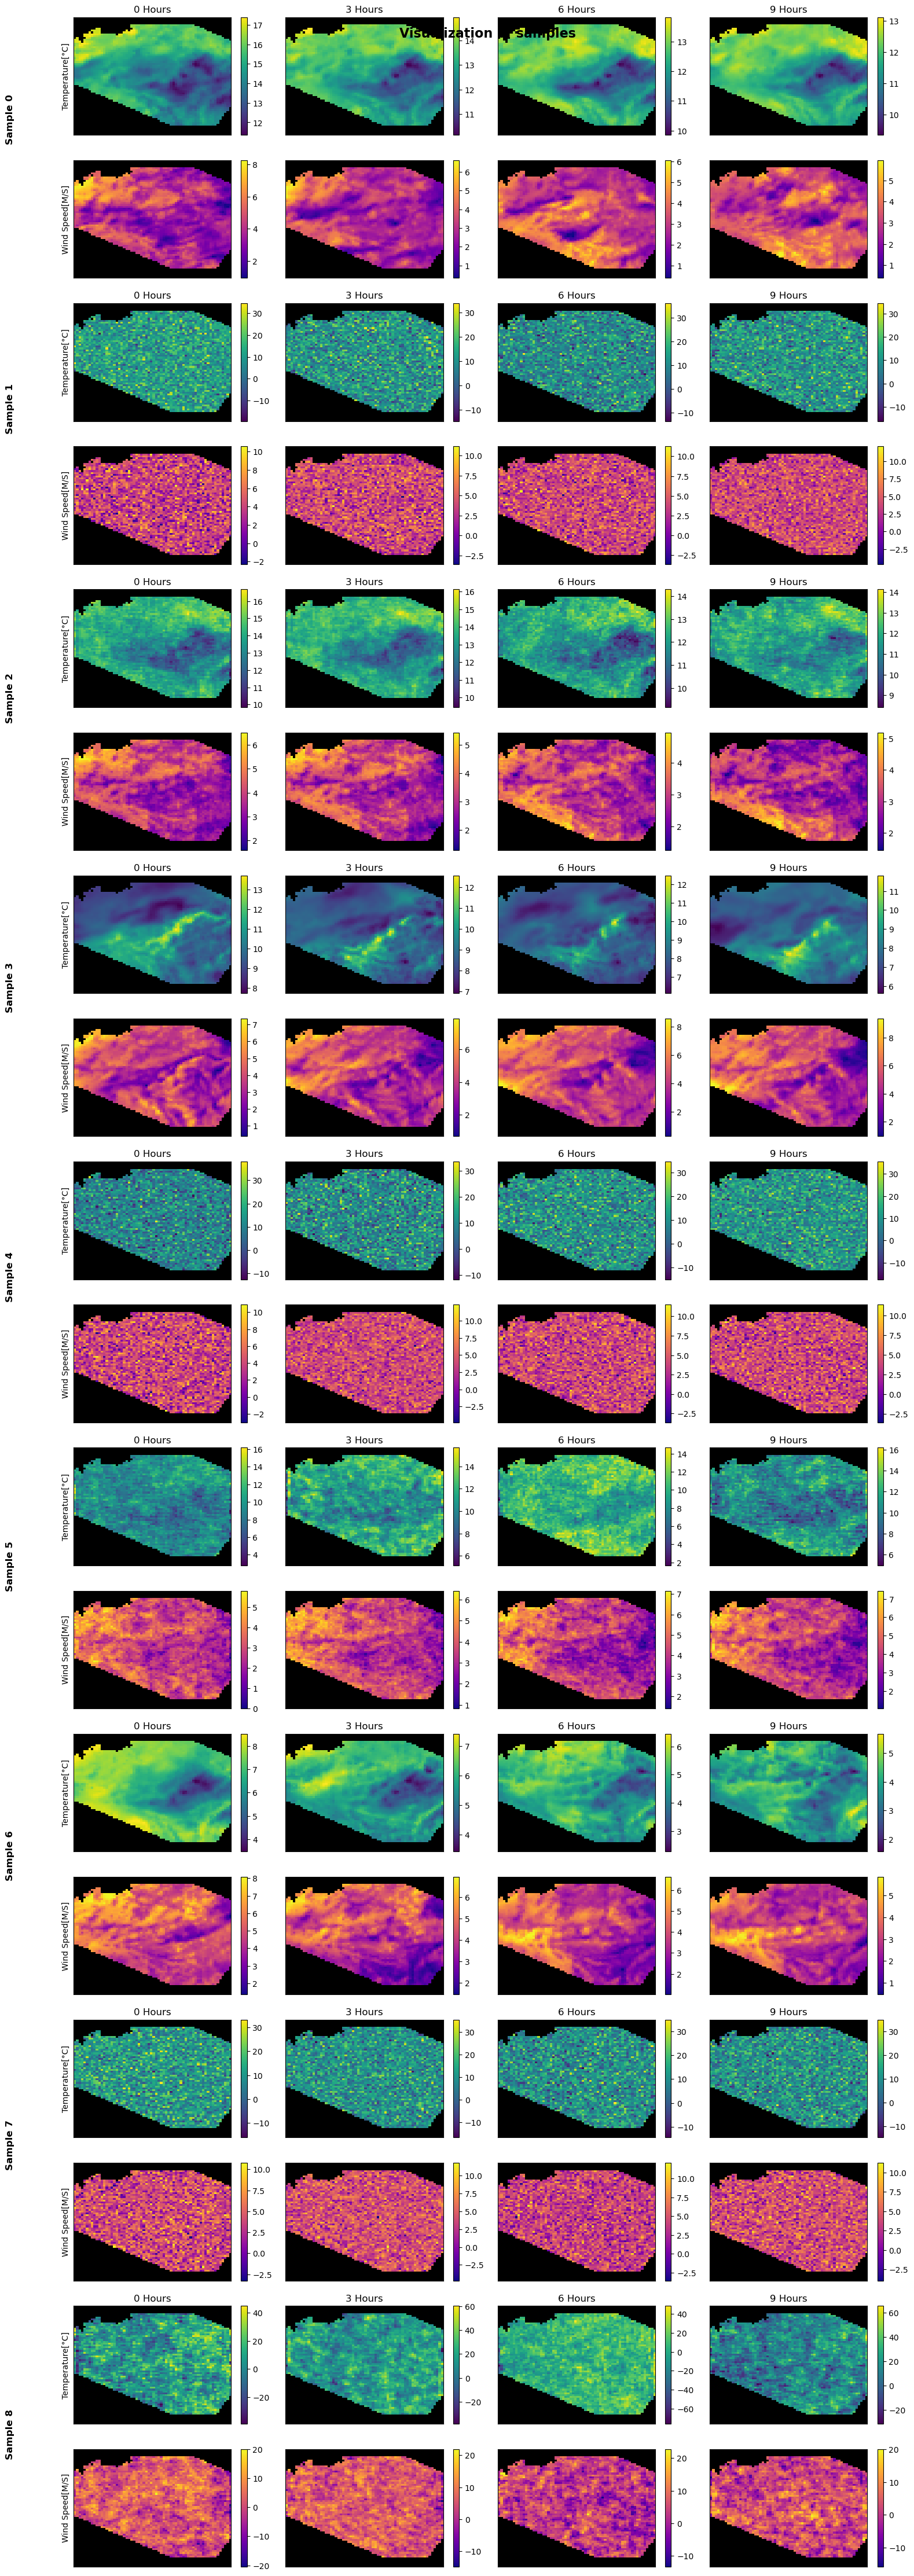

In [8]:
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
new_tensor = torch.stack((batch,x_t,x_0), dim=1).flatten(0,1).detach().cpu()

fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [10]:
from TFE.metric.model import *
efficient_net = EfficientNet()
checkpoint_eff_path = 'efficientnet_finetuned.pth'
checkpoint = torch.load(checkpoint_eff_path, map_location='cpu', weights_only=True)
efficient_net.load_state_dict(checkpoint)
label = ['p(x)','samples']

In [11]:
efficient_net.eval()
with torch.no_grad():
    output = efficient_net(sample.cpu()[:100])
    prob = torch.nn.functional.softmax(output, dim = 1)
    _, preds = torch.max(output, 1)
    print(preds)
    for i in range(len(preds)):
        print(f"{label[preds[i]]} with {prob[i,preds[i]]*100} %")

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
samples with 99.9999771118164 %
samples with 99.99998474121094 %
samples with 99.99998474121094 %
samples with 100.0 %
samples with 99.9999771118164 %
samples with 100.0 %
samples with 99.99996185302734 %
samples with 99.99998474121094 %
samples with 99.99991607666016 %
samples with 99.99742126464844 %
samples with 99.99949645996094 %
samples with 99.99998474121094 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 99.99864959716797 %
samples with 100.0 %
samples with 100.0 %
samples with 99.98212432861328 %
samples with 100.0 %
samples with 100.0 %
samples with 

tensor([[1.0775e-05, 9.9999e-01],
        [5.4763e-07, 1.0000e+00],
        [1.1544e-06, 1.0000e+00],
        [2.8063e-06, 1.0000e+00],
        [1.4763e-06, 1.0000e+00],
        [1.9036e-05, 9.9998e-01],
        [2.3095e-05, 9.9998e-01],
        [1.3038e-04, 9.9987e-01]])


In [12]:
with torch.no_grad():
    output = efficient_net(batch.cpu()[:100])
    prob = torch.nn.functional.softmax(output, dim = 1)
    _, preds = torch.max(output, 1)
    for i in range(len(preds)):
        print(f"{label[preds[i]]} with {prob[i,preds[i]]*100} \%")

p(x) with 52.45684814453125 \%
p(x) with 100.0 \%
p(x) with 99.8519515991211 \%
p(x) with 99.81676483154297 \%
p(x) with 98.42560577392578 \%
p(x) with 98.56414031982422 \%
p(x) with 99.543212890625 \%
p(x) with 99.99998474121094 \%
p(x) with 99.99519348144531 \%
p(x) with 59.67657470703125 \%
p(x) with 86.65282440185547 \%
p(x) with 100.0 \%
p(x) with 99.87176513671875 \%
p(x) with 100.0 \%
p(x) with 99.99122619628906 \%
p(x) with 99.98057556152344 \%
samples with 99.92532348632812 \%
p(x) with 98.16454315185547 \%
p(x) with 99.99858093261719 \%
p(x) with 99.99993896484375 \%
p(x) with 100.0 \%
p(x) with 99.90042114257812 \%
p(x) with 99.99639129638672 \%
p(x) with 99.9999771118164 \%
p(x) with 99.72872924804688 \%
p(x) with 97.76738739013672 \%
p(x) with 99.99979400634766 \%
p(x) with 99.98143005371094 \%
p(x) with 96.3692626953125 \%
samples with 73.38825225830078 \%
p(x) with 99.99967956542969 \%
p(x) with 99.99232482910156 \%
p(x) with 99.99617004394531 \%
p(x) with 100.0 \%
p(x) 

In [ ]:
from TFE.utils import *
process_file = Path('data/processed/train.h5')
samples_file = Path('generated_samples.h5')

process_dataset =  SequenceDataset(file=process_file, window=12, flatten=True, slicer=slice(3000))
samples_dataset = BatchDataset(file=samples_file, data_keyword='samples')
print(len(process_dataset))
print(len(samples_dataset))

In [16]:
for name, param in vpsde.named_parameters():
    if param.requires_grad:
        print(f"Trainable parameter: {name} | Shape: {param.shape}")

Trainable parameter: eps.embedding.0.weight | Shape: torch.Size([256, 64])
Trainable parameter: eps.embedding.0.bias | Shape: torch.Size([256])
Trainable parameter: eps.embedding.2.weight | Shape: torch.Size([64, 256])
Trainable parameter: eps.embedding.2.bias | Shape: torch.Size([64])
Trainable parameter: eps.network.heads.0.weight | Shape: torch.Size([64, 28, 3, 3])
Trainable parameter: eps.network.heads.0.bias | Shape: torch.Size([64])
Trainable parameter: eps.network.heads.1.0.weight | Shape: torch.Size([128, 64, 3, 3])
Trainable parameter: eps.network.heads.1.0.bias | Shape: torch.Size([128])
Trainable parameter: eps.network.heads.2.0.weight | Shape: torch.Size([128, 128, 3, 3])
Trainable parameter: eps.network.heads.2.0.bias | Shape: torch.Size([128])
Trainable parameter: eps.network.heads.3.0.weight | Shape: torch.Size([256, 128, 3, 3])
Trainable parameter: eps.network.heads.3.0.bias | Shape: torch.Size([256])
Trainable parameter: eps.network.tails.0.2.weight | Shape: torch.Size